In [270]:
from __future__ import division
from __future__ import print_function
import pandas as pd
%pylab inline
import time
import warnings
import os
from collections import Counter
from itertools import chain
import json
import seaborn as sns
import ast
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
import sklearn.preprocessing

print("Imports done ...✈✈✈✈✈✈✈✈ You are free to go.")
import keras
from keras.layers import Activation,Dense
from keras.models import Sequential
import tensorflow as tf
import six
from sklearn.datasets import load_breast_cancer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib
Imports done ...✈✈✈✈✈✈✈✈ You are free to go.


/home/cts/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [271]:
dataset_folder = './crowdsignals'
fname = 'chapter5_result.csv'
dataset_path = os.path.join(dataset_folder,fname)
print(dataset_path)
print(os.getcwd())
print(os.listdir(dataset_folder))

./crowdsignals/chapter5_result.csv
/home/cts/Desktop/ML4QS/Assignments/assignments_code_git/assignment2
['chapter3_result_outliers.csv', 'chapter2_result.csv', 'chapter3_result_final.csv', 'chapter4_result.csv', '.~lock.chapter2_result.csv#', 'chapter5_result.csv']


#### Chapter 6.2
Explore gradient descent and change the learning rate η. What happens to the trajectory of the gradient descent? Is a fast gradient descent always a good idea? (Hint: the answer is No!).


------
In most classification problems, the cost function we want to approximate is highly convex. So to approximate it fast we might need a large learning rate. However this can backfire as the error loss gets bouncing around the downhill slope toward the local minima. This is called overshooting. An example is illustrated in the picture below. Note that these images are an ideal case for illustrating how the learning rate affects the optimization of our cost function.

<img src="sgd.png">
In addition we show a coding example on the crowdsignal data with a simple MLP implemented in keras to show how sgd learning rate affects training.

In [272]:
def mlp_model(D,nb_classes=10):
    
    model = Sequential()
    input_shape = (D,)
#     print(input_shape,' input dimensions')
    layers = [
        Dense(100,name='fc1',input_shape=input_shape),
        Activation('tanh',name='fc1_act'),
        Dense(20,name='fc2'),
        Activation('tanh',name='fc2_act'),
        Dense(nb_classes,name='fc_out'),
        Activation('softmax',name='output')
    ]
    for layer in layers:
#         print('Added layer:%s'%layer.name)
        model.add(layer)

    return model

def batch_indices(batch_nb, data_length, batch_size):
    """
    This helper function computes a batch start and end index
    :param batch_nb: the batch number
    :param data_length: the total length of the data being parsed by batches
    :param batch_size: the number of inputs in each batch
    :return: pair of (start, end) indices
    """
    # Batch start and end index
    start = int(batch_nb * batch_size)
    end = int((batch_nb + 1) * batch_size)

    # When there are not enough inputs left, we reuse some to complete the
    # batch
    if end > data_length:
        shift = end - data_length
        start -= shift
        end -= shift

    return start, end



def model_eval(sess, x, y, model, X_test, Y_test, args=None):

    
    # Define accuracy symbolically
    correct_preds = tf.equal(tf.argmax(y, axis=tf.rank(y) - 1),
                                 tf.argmax(model, axis=tf.rank(model) - 1))
    acc_value = tf.reduce_mean(tf.to_float(correct_preds))
    
    # Init result var
    accuracy = 0.0
    preds = np.zeros(Y_test.shape[0])
    logits = np.zeros((Y_test.shape[0],2))
    with sess.as_default():

        nb_batches = int(math.ceil(float(len(X_test)) / args['batch_size']))

        for batch in range(nb_batches):

            start = batch * args['batch_size']
            end = min(len(X_test), start + args['batch_size'])
            cur_batch_size = end - start

            cur_acc, cur_preds,cur_logits  = sess.run([acc_value, correct_preds,model],
                                          feed_dict={x: X_test[start:end],
                                                     y: Y_test[start:end]})
            accuracy += (cur_batch_size * cur_acc)
            preds[start:end, ] = cur_preds
            logits[start:end,:] = cur_logits

        # Divide by number of examples to get final value
        accuracy /= len(X_test)

    return accuracy, preds ,logits

def model_train(sess, x, y, predictions, X_train, Y_train,args=None,verbose=True, init_all=True):
    
    loss = model_loss(y, predictions)
    
    train_step = tf.train.GradientDescentOptimizer(learning_rate=args['learning_rate']).minimize(loss)
    losses = []
    with sess.as_default():
        if hasattr(tf, "global_variables_initializer"):
            if init_all:
                tf.global_variables_initializer().run()
        prev = time.time()
        
        for epoch in six.moves.xrange(args['nb_epochs']):
            
            nb_batches = int(math.ceil(float(len(X_train)) / args['batch_size']))
            epoch_loss = 0.0
            for batch in range(nb_batches):
                start, end = batch_indices(batch, len(X_train), args['batch_size'])
                cur_loss,_ =  sess.run([loss,train_step],feed_dict={x: X_train[start:end],
                                          y: Y_train[start:end]})
                cur_loss /= args['batch_size']
                epoch_loss += cur_loss
            epoch_loss /= nb_batches
            
            if epoch % 100 == 0 and verbose:
                
                print("Epoch %d/%d took %s seconds,\t average loss is :%e"
                        %(epoch+1,args['nb_epochs'], str(time.time() - prev),epoch_loss))
                prev = time.time()
                
            losses.append(epoch_loss)
        if verbose:
            print("Epoch %d/%d \t Final loss is %2.8f:"
              %(epoch+1,args['nb_epochs'],losses[-1]))
    return losses
                
def model_loss(y, model, mean=True):

    op = model.op
    if "softmax" in str(op).lower():
        logits, = op.inputs
    else:
        logits = model

    out = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

    if mean:
        out = tf.reduce_mean(out)
    return out

def data_prepare(df_name):
    
    df = pd.read_csv(df_name,index_col=0)
    x_columns = ['acc_phone_x','acc_phone_y','acc_phone_z',
                 'acc_watch_x','acc_watch_y','acc_watch_z',
                 'gyr_phone_x','gyr_phone_y','gyr_phone_z',
                 'hr_watch_rate',
                ]
    y_columns = ['labelOnTable','labelSitting','labelWashingHands',
                 'labelWalking','labelStanding','labelDriving',
                 'labelEating','labelRunning'
                ]
    X = df[x_columns]
    Y = df[y_columns]
    return X,Y

    
   

In [273]:
X,Y = data_prepare(dataset_path)

keras.layers.core.K.set_learning_phase(0)
keras.backend.manual_variable_initialization(True)
# Set TF random seed to improve reproducibility
tf.set_random_seed(42)

sess = tf.Session()
keras.backend.set_session(sess)
classes = np.arange(Y.shape[1])
D = (X.shape[1])
x = tf.placeholder(tf.float32, shape=(None, D))
y = tf.placeholder(tf.float32, shape=(None, len(classes)))
print("Created TensorFlow session and set Keras backend.")
batch_size = 1024
nb_epochs = 1000
learning_rate = 1e-3
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

print('Number of classes %d'%len(classes))

model = mlp_model(D,nb_classes=len(classes))
preds = model(x)
losses1 = model_train(sess,x,y,preds,X,Y,args=train_params)
learning_rate = 1
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
losses2 = model_train(sess,x,y,preds,X,Y,args=train_params)


Created TensorFlow session and set Keras backend.
Number of classes 8
Epoch 1/1000 took 0.511641025543 seconds,	 average loss is :1.375128e-03
Epoch 101/1000 took 0.884489059448 seconds,	 average loss is :1.120450e-03
Epoch 201/1000 took 0.83746099472 seconds,	 average loss is :1.065909e-03
Epoch 301/1000 took 0.859642982483 seconds,	 average loss is :1.030184e-03
Epoch 401/1000 took 0.864598035812 seconds,	 average loss is :1.006205e-03
Epoch 501/1000 took 1.00879979134 seconds,	 average loss is :9.884217e-04
Epoch 601/1000 took 0.94447684288 seconds,	 average loss is :9.743253e-04
Epoch 701/1000 took 1.03963804245 seconds,	 average loss is :9.625699e-04
Epoch 801/1000 took 0.844920873642 seconds,	 average loss is :9.523896e-04
Epoch 901/1000 took 0.900503873825 seconds,	 average loss is :9.433297e-04
Epoch 1000/1000 	 Final loss is 0.00093514:
Epoch 1/1000 took 0.0158989429474 seconds,	 average loss is :2.116320e-03
Epoch 101/1000 took 1.03128910065 seconds,	 average loss is :3.69980

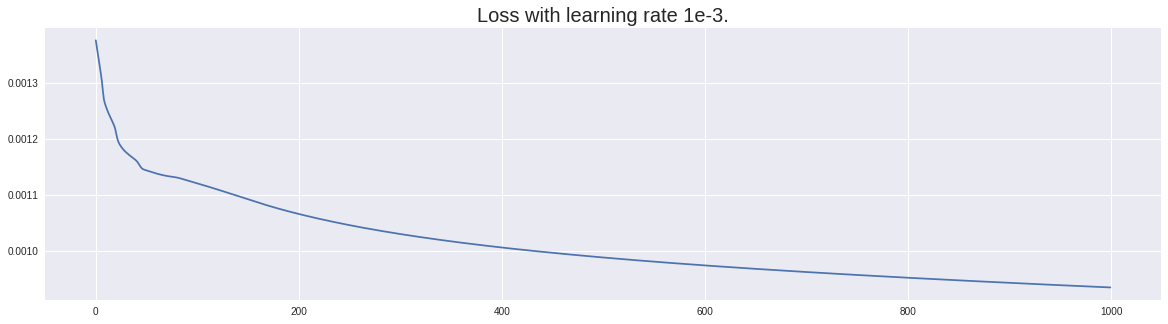

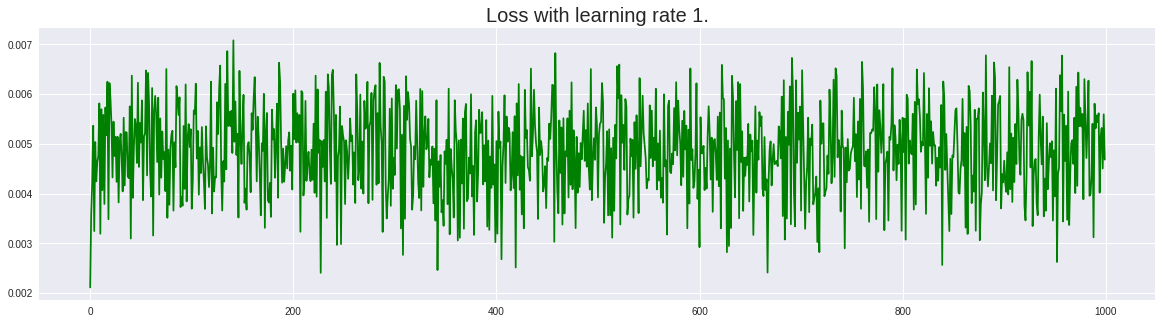

In [274]:
rcParams['figure.figsize'] = (20,5)
plt.plot(losses1);
plt.title('Loss with learning rate 1e-3.',fontsize=20)
plt.savefig('low_rate.png')
plt.show()
plt.plot(losses2,c='g');
plt.title('Loss with learning rate 1.',fontsize=20)
plt.savefig('high_rate.png')
plt.show()


 From the above figures we can see the multiple oscillations the loss function does on the training set. Both training sessions where on an Multilayer perceptron with 2 hidden layers with 100 and 50 neurons respectively. Batch size was fixed at 1024 and epochs where 1000. Both models were trained on the crowdsignals dataset using 
sensors such as accelerometer (phone,watch),gyroscope and heart rate to predict the labels given.

## Chapter 6.3
For answering this question we will be using scikit's breast cancer dataset https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic

In [275]:
def roc_curve(P):
    roc_curve_points = []
    N = P.shape[0]
    pos = np.where(P[:,1]==1)[0].shape[0]
    neg = N-pos
    unique_probs = np.unique(P)
    for p in unique_probs[::-1]:
        P_select = np.where(P[:,0]>=p)[0]
        neg_point = np.where(P[P_select,1]==0)[0].shape[0]/neg
        pos_point = np.where(P[P_select,1]==1)[0].shape[0]/pos
        point = [neg_point,pos_point]
        roc_curve_points.append(point)
    
    return np.array(roc_curve_points)


In [276]:
np.random.seed(42)
tf.set_random_seed(42)
data = load_breast_cancer()
X = data.data
Y = data.target
sess = tf.Session()
keras.backend.set_session(sess)
YY = np.zeros((Y.shape[0],2))
for i,v in enumerate(Y):
    if v == 0:
        YY[i,:] = [1,0]
    else:
        YY[i,:] = [0,1]
Y = YY
print(Y.shape)
D = X.shape[1]
classes =[0,1]
x = tf.placeholder(tf.float32, shape=(None, D))
y = tf.placeholder(tf.float32, shape=(None, len(classes)))
print("Created TensorFlow session and set Keras backend.")
batch_size = 1024
nb_epochs = 500
learning_rate = 1e-3
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

print('Number of classes %d'%len(classes))
model = mlp_model(D,nb_classes=len(classes))
preds = model(x)
model_train(sess,x,y,preds,X,Y,args=train_params,verbose=True);


(569, 2)
Created TensorFlow session and set Keras backend.
Number of classes 2
Epoch 1/500 took 0.00946497917175 seconds,	 average loss is :1.477417e-03
Epoch 101/500 took 0.247231006622 seconds,	 average loss is :3.768516e-04
Epoch 201/500 took 0.249839067459 seconds,	 average loss is :3.528682e-04
Epoch 301/500 took 0.345941066742 seconds,	 average loss is :3.029678e-04
Epoch 401/500 took 0.313313007355 seconds,	 average loss is :2.822409e-04
Epoch 500/500 	 Final loss is 0.00027365:


In [277]:
acc,predictions,logits = model_eval(sess,x,y,preds,X,Y,args={'batch_size':batch_size})
indices = logits[:,1] > logits[:,0]

P = np.zeros((len(indices),2))
P[:,0] = np.max(logits,axis=1)
P[:,1] = np.argmax(logits,axis=1)

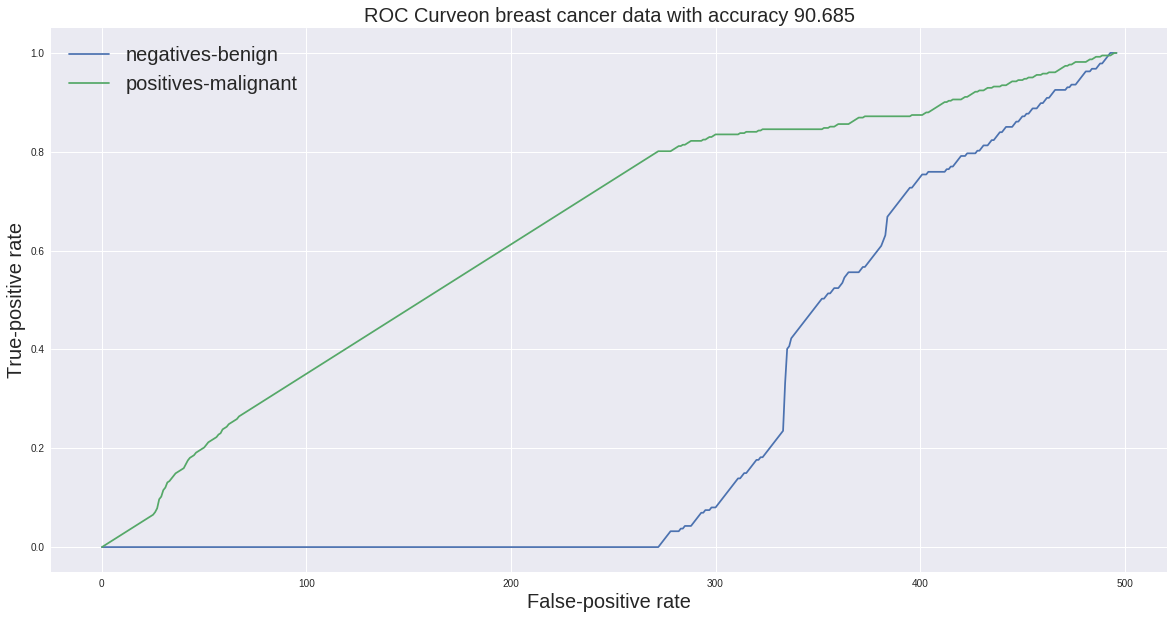

In [278]:
roc_points = roc_curve(P)
rcParams['figure.figsize'] = (20,10)
plt.plot(roc_points)
plt.legend(['negatives-benign','positives-malignant'],fontsize=20)
plt.ylabel('True-positive rate',fontsize=20)
plt.xlabel('False-positive rate',fontsize=20)
plt.title('ROC Curveon breast cancer data with accuracy %.3f'%(acc*100),fontsize=20)
plt.savefig('roc_curve.png')
plt.show()

# Chapter 6.4
When having more features than data points, we are left with having a multiple (sometimes infinite) set of functions as a solution to the empirical risk minimization. This reduces our generalization for the data, causing us to overfit in the training set. In order to avoid this we need to introduce some constraints to our model. Such a constraint is often called regularization, wich introduces a new parameter to the error function so we can penalize the weights of the features in the data. Other models such as SVMs work by default with this parameter, through the introduction of lagrangian multipliers (more constraints). Other methods also for such occasions is by using Maximum Aposteriori methods, which are often used in Bayesian Learning (Penalized Maximum Likelihood). To show a simple example we will use l1 regularization which has multiple solutions on how affects the predictions variance and accuracy overall for a binary classification with logistic regression from toy data generated randomly but are not linear dependendent.

In [260]:
# X1 ~ N(X|0,1)
X1 = np.random.rand(140,1024)
Y1 = np.ones(X1.shape[0])
# X2 ~ N(X|5,3.0)
X2 = 5. + 3.0*np.random.randn(30,1024)
Y2 = np.zeros(X2.shape[0])
X = np.concatenate((X1,X2),axis=0)
Y = np.concatenate((Y1,Y2),axis=0)
Y = Y.astype(int)
label = Y
# YY = np.zeros((Y.shape[0],2))
# for i,v in enumerate(Y):
#     if v == 0:
#         YY[i,:] = [1,0]
#     else:
#         YY[i,:] = [0,1]
# Y = YY
N,D = X.shape
indices = np.arange(N)
cutout = int(0.9 * len(indices))
np.random.shuffle(indices)
X_train = X[indices[cutout:-1]]
Y_train = Y[indices[cutout:-1]]
X_test  = X[indices[:cutout]]
Y_test  = Y[indices[:cutout]]
print('Train set size: %d \tTest set size:%d'%(X_train.shape[0],X_test.shape[0]))
print("Dimensionality:%d"%(X_train.shape[1]))

Train set size: 16 	Test set size:153
Dimensionality:1024


Number of points: 169 <br>
Dimensionality: 1024 <br>
Train/Test cutout: 16-153 points. <br> 
Below are the results.

In [267]:
accuracies  = []
predictions = []
N_trials = 10
for i in range(N_trials):
    clf = LogisticRegression('l1')
    clf.fit(X_train,Y_train)
    Y_preds = clf.predict_proba(X_test)
    correct = np.argmax(Y_preds,axis=1) == Y_test
    acc = np.sum(correct)/correct.shape[0]
    accuracies.append(acc)
    predictions.append(Y_preds)


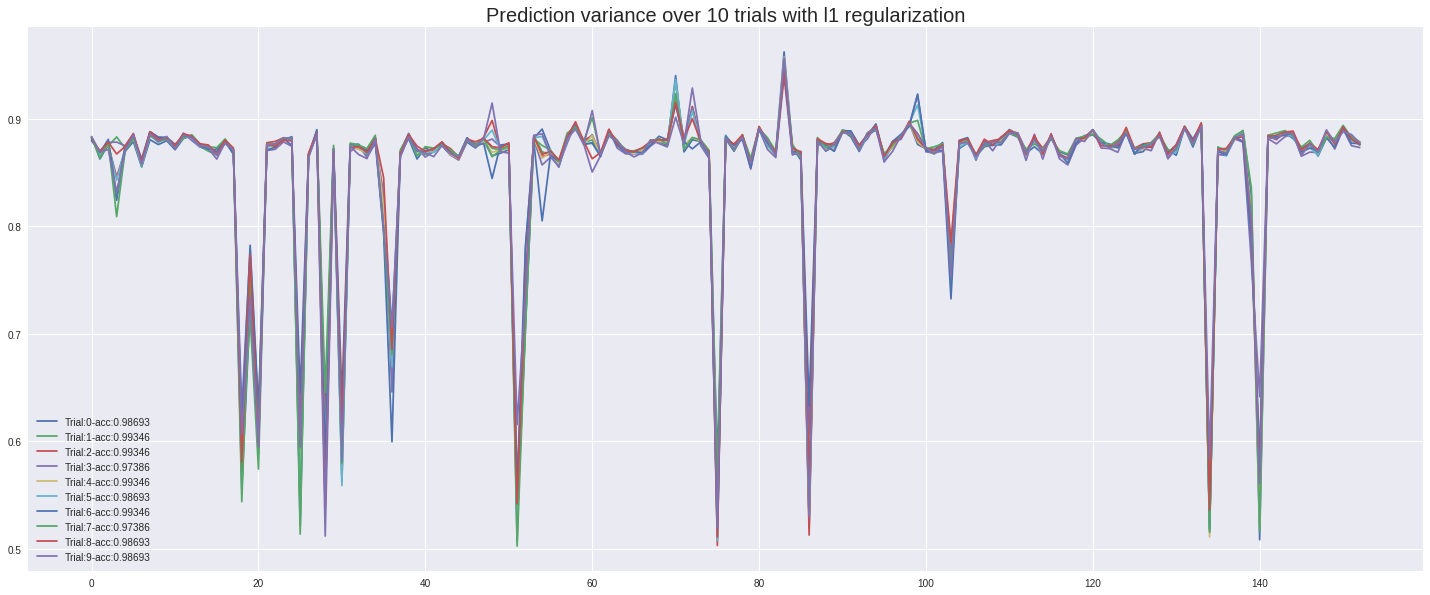

In [268]:
for i in range(N_trials):
    pred = np.max(predictions[i],axis=1)
    plt.plot(pred)
rcParams['figure.figsize'] = (25,10)
leg = ['Trial:%d-acc:%.5f'%(i,accuracies[i]) for i in range(N_trials) ]
plt.legend(leg)
plt.title('Prediction variance over %d trials with l1 regularization'%N_trials,fontsize=20)
plt.savefig('6_4trials_logreg.png')
plt.show()

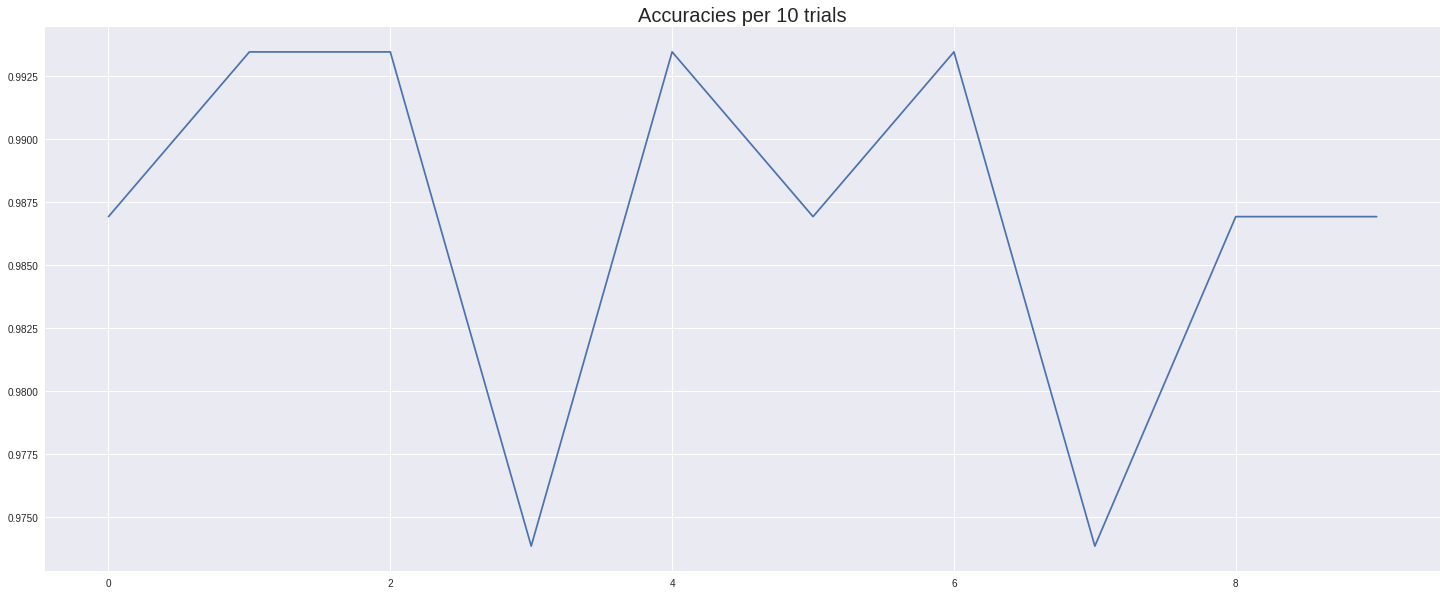

In [269]:
plt.plot(accuracies)
plt.title('Accuracies per %d trials'%N_trials,fontsize=20)
plt.savefig('6_4trials_logreg_accuracy.png')
plt.show()